# BNN on Pynq

This notebook covers how to use Binary Neural Networks on Pynq. 
It shows an example of image recognition with a binarized neural inspired at VGG-16, featuring 6 convolutional layers, 3 Max Pool layers and 3 Fully connected layers

## 1. Instantiate a Classifier

Creating a classifier will automatically download the correct bitstream onto the device and load the weights trained on the specified dataset. By default there are three sets of weights to choose from - this example uses the CIFAR10 set.

In [1]:
import bnn
print(bnn.available_params(bnn.NETWORK_CNV))

classifier = bnn.CnvClassifier('cifar10')

['streetview', 'cifar10', 'road-signs']


# 2. List the available classes
The CIFAR10 dataset has 10 classes of images, the names of which are accessible through the classifier.

In [2]:
print(classifier.bnn.classes)

['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


# 3. Open image to be classified
Download a JPEG image of a car and place it in the home directory for the xilinx user. The image can then be loaded and displayed through the notebook

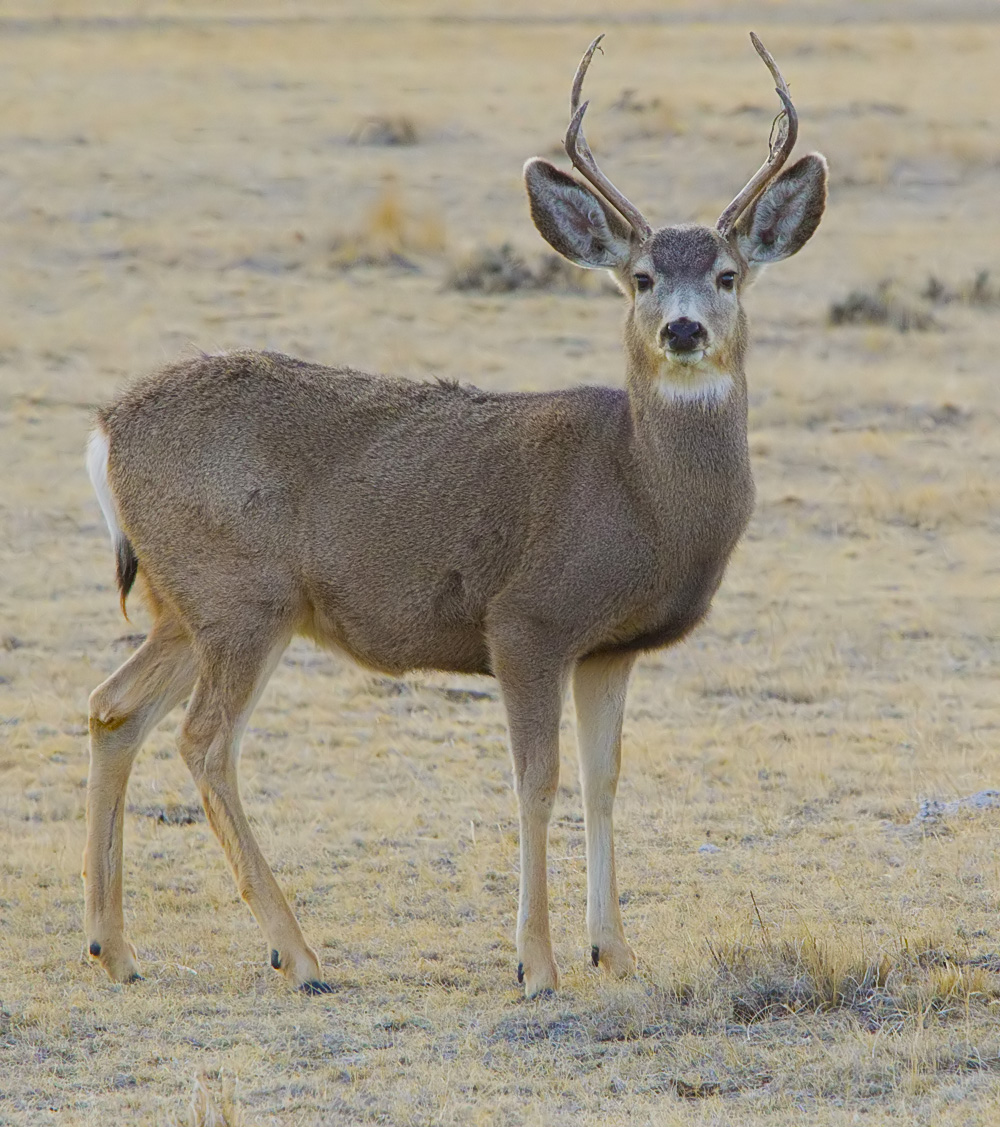

In [3]:
from PIL import Image
import numpy as np

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/deer.jpg')
im 

# 4. Launching BNN in hardware
The image is passed into the PL and the inference is performed. The Python API takes care of resizing the image to that required by the network and transferring the image between hardware and software.

In [4]:
class_out=classifier.classify_image(im)
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(classifier.class_name(class_out)))

Inference took 1584.00 microseconds
Classification rate: 631.31 images per second
Class number: 4
Class name: Deer


# 5. Launching BNN in software
As a comparision, the same image can be classified using a software implementation of the algorithm by passing the RUNTIME_SW parameter to the ImageClassifier

In [5]:
sw_class = bnn.CnvClassifier("cifar10", bnn.RUNTIME_SW)

class_out = sw_class.classify_image(im)
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(classifier.class_name(class_out)))

Inference took 821773.00 microseconds
Classification rate: 1.22 images per second
Class number: 4
Class name: Deer


As can be seen, the software implementation is several orders of magnitude slower than the hardware implementation.

# 6. Detailed Classification Information

In addition to highest ranked class, it is possible to get the rank of every class using the `classify_details` function. To run this example, take another couple of images of a car, an airplane, and a bird and place them in the home directory.

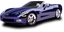

Inference took 1602.00 microseconds
Classification rate: 624.22 images per second
Car classes: [256 379 165 169 163 244 249 244 267 268]


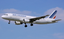

Inference took 1591.00 microseconds
Classification rate: 628.54 images per second
Airplane classes: [378 283 277 277 271 132 137 262 263 266]


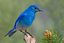

Inference took 1586.00 microseconds
Classification rate: 630.52 images per second
Bird classes: [249 184 408 274 284 249 252 245 248 163]


In [6]:
from IPython.display import display

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/car.png')
im.thumbnail((64, 64), Image.ANTIALIAS)
display(im) 
car_class = classifier.classify_details(im)
print("Car classes: {0}".format(car_class))

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/airplane.jpg')
im.thumbnail((64, 64), Image.ANTIALIAS)
display(im) 
air_class = classifier.classify_details(im)
print("Airplane classes: {0}".format(air_class))

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/bird.jpg')
im.thumbnail((64, 64), Image.ANTIALIAS)
display(im) 
bird_class = classifier.classify_details(im)
print("Bird classes: {0}".format(bird_class))

The numbers can be difficult to visualise so we can use matplotlib to graph the output.

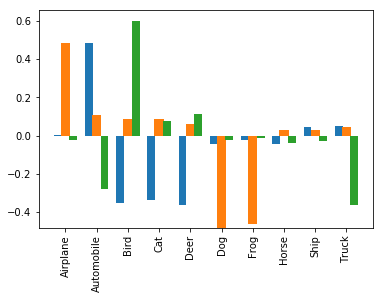

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

x_pos = np.arange(len(car_class))
fig, ax = plt.subplots()
ax.bar(x_pos - 0.25, (car_class/255)-1, 0.25)
ax.bar(x_pos, (air_class/255)-1, 0.3)
ax.bar(x_pos + 0.25, (bird_class/255)-1, 0.25)
ax.set_xticklabels(classifier.bnn.classes, rotation='vertical')
ax.set_xticks(x_pos)
ax.set
plt.show()

# Classifying multiple images

This example is going to create a string of images from a single input image, tiling the image to try and locate an object. This image is a somewhat empty looking motorway and the aim is to find the cars.

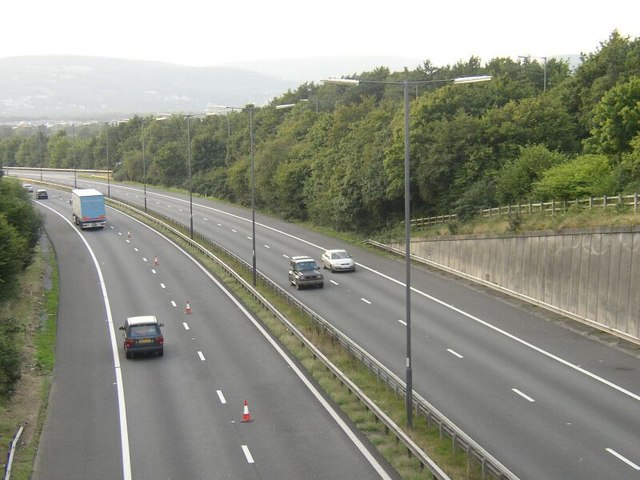

In [8]:
im = Image.open('/home/xilinx/jupyter_notebooks/bnn/motorway.jpg')
im

First task is to create a set of image tiles from large image to search. Different scales allow the network to check for different sized cars.

In [9]:
images = []
bounds = []
for s in [32, 64]:
    stride =  s // 2
    x_tiles = im.width // stride
    y_tiles = im.height // stride
    
    for j in range(y_tiles):
        for i in range(x_tiles):
            bound = (stride * i, stride * j, stride * i + s, stride * j + s)
            if bound[2] <= im.width and bound[3] < im.height:
                c = im.crop(bound)
                images.append(c)
                bounds.append(bound)

print(len(images))

1339


Next the set of images are passed through the classifier. Note how the rate of images is 3 times greater than for single image classification. Once the classes are returned, numpy can quickly find all of the indicies of tiles which have matched as cars.

In [10]:
results = classifier.classify_images(images)
cars = results == 1
indicies = cars.nonzero()[0]

Inference took 440638.02 microseconds, 329.08 usec per image
Classification rate: 3038.78 images per second


To visualise the output we can draw the bounds of each matched rectangle on the original image.

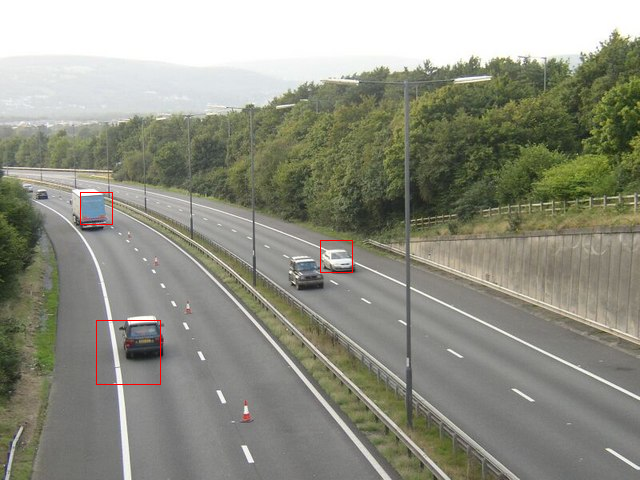

In [11]:
from PIL import ImageDraw

draw = ImageDraw.Draw(im)
for i in indicies:
    draw.rectangle(bounds[i], outline='red')

im

## Reseting the device

In [12]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()